# Generating Fashion MNIST Apparel using DCGANs

## Importing Libraries

In [1]:
import os
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
%matplotlib inline

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset & Data Loader

In [2]:
# 1. Prepare data directory
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

In [3]:
# 2. Define hyperparameters
image_size = 28    # 28×28 pixels
batch_size = 128
stats = ((0.5,), (0.5,))  # mean, std for single channel

In [4]:
# 3. Compose transforms
data_transform = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [5]:
# 4. Load dataset
train_ds = FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=data_transform
)

In [6]:
# 5. Create DataLoader (CPU-only)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=False  # pin_memory only helps GPU transfers
)

In [7]:
# 6. Denormalization helper
def denorm(imgs):
    """Map from [-1,1] to [0,1]"""
    return imgs * stats[1][0] + stats[0][0]

In [8]:
# 7. Display single image
def show_images(images, nmax=64):
    grid = make_grid(denorm(images[:nmax]), nrow=8)
    np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(np_grid)
    plt.show()

## Visualizing a Batch of Real Images

In [9]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

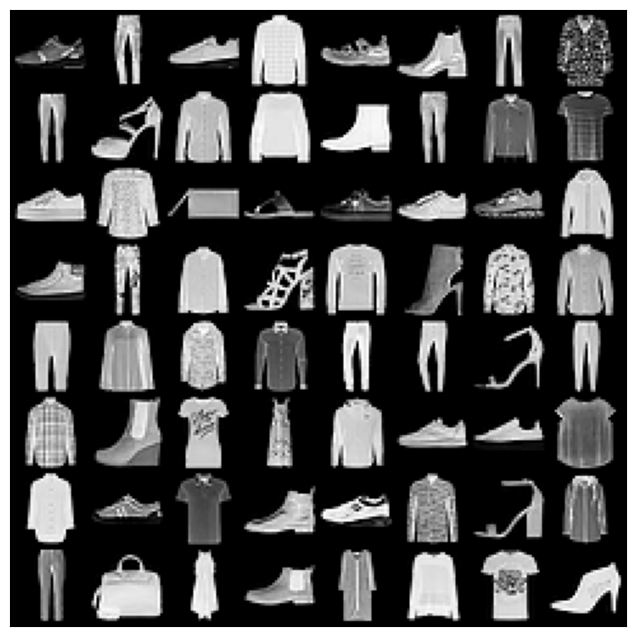

In [10]:
show_batch(train_dl)

## Discriminator Network

The discriminator is a CNN that outputs a probability (real vs fake):

In [11]:
discriminator = nn.Sequential(
    # in: 1 x 28 x 28
    nn.Conv2d(1, 28, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(28),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 28 * 14 * 14

    # in: 28 x 14 x 14
    nn.Conv2d(28, 56, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(56),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 56 x 7 x 7

    # in: 56 x 7 x 7
    nn.Conv2d(56, 112, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(112),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 112 x 3 x 3

    #Add only conv2d layer here to output 1x1x1 value
    nn.Conv2d(112, 1, kernel_size=3, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

## Generator Network
The generator uses ConvTranspose2d to upsample from a 128-dim latent vector:

In [12]:
latent_size = 100

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 128, kernel_size=7, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 7 x 7

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 14 x 14

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 28 x 28
)

torch.Size([128, 1, 28, 28])


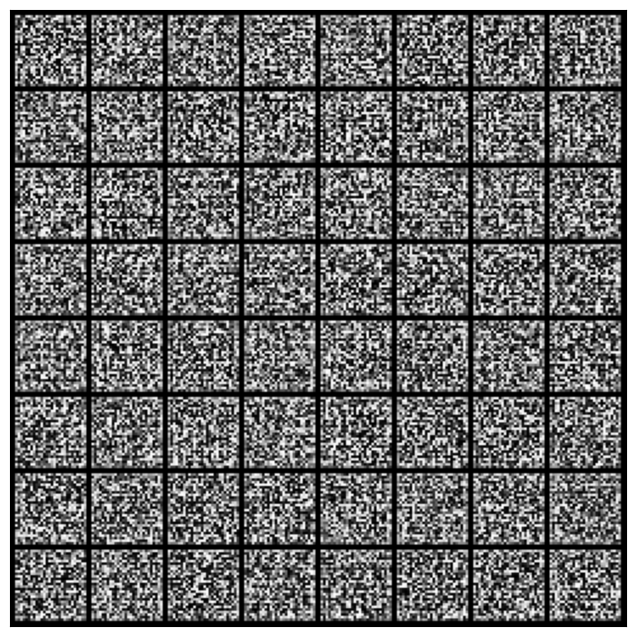

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

## Discriminator Training

For each real batch:
1. Compute BCE loss against 1’s  
2. Generate fake images, compute BCE loss against 0’s  
3. Backprop & update *only* discriminator’s weights

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through the discriminator 
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent).detach()

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

## Generator Training

1. Generate fake images  
2. Pass them to the discriminator  
3. Compute BCE loss against 1’s (generator “wants” them to look real)  
4. Backprop & update *only* generator’s weights

In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples

Use a fixed latent tensor to track progression over epochs:
- Saves **8×8 grid** images as `generated-images-XXXX.png`

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999845..0.99998146].


Saving generated-images-0000.png


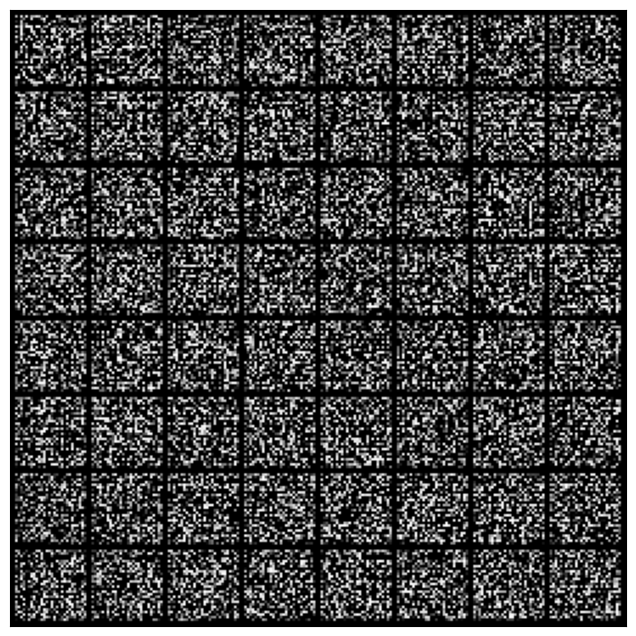

In [19]:
fixed_latent = torch.randn(64, latent_size, 1, 1)
save_samples(0, fixed_latent)

## Full Training Loop

Alternately train discriminator & generator across **N epochs**:
- Record and print losses & real/fake scores  
- Save sample images every epoch

In [ ]:
def fit(epochs, lr, start_idx=1):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        epoch_real_score = 0.0
        epoch_fake_score = 0.0
        n_batches = 0

        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            # Train generator 
            loss_g = train_generator(opt_g)

            epoch_d_loss += loss_d
            epoch_g_loss += loss_g
            epoch_real_score += real_score
            epoch_fake_score += fake_score
            n_batches += 1
            
        # Record losses & scores
        losses_g.append(epoch_g_loss / n_batches)
        losses_d.append(epoch_d_loss / n_batches)
        real_scores.append(epoch_real_score / n_batches)
        fake_scores.append(epoch_fake_score / n_batches)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores
        

: 

In [ ]:
lr = 0.0002
epochs = 15

history = fit(epochs, lr)

losses_g, losses_d, real_scores, fake_scores = history

  0%|          | 0/469 [00:00<?, ?it/s]

  3%|▎         | 15/469 [00:27<13:04,  1.73s/it]

## Checkpointing
After training, save model weights:
```python
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0025.png')

## Plotting Loss of Generator & Discriminator

In [ ]:
epochs_range = list(range(1, len(losses_d) + 1))

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Real & Fake Scores

In [ ]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()